# **Εργασία 2 Κβαντική Μηχανική Μάθηση**
Ονοματεπώνυμο: Μανίκα Θεοδώρα

ΑΜ: 1115202100267

Προπτυχιακή φοιτήτρια- 4o έτος

# Download and import libraries

In [1]:
!pip install pennylane qutip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 30.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from pennylane import numpy as qnp
from qutip import Bloch, Qobj, sigmax, sigmay, sigmaz
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


# Data Loading

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Navigate to files
data_path = '/content/drive/MyDrive/data/'
os.chdir(data_path)

Mounted at /content/drive


In [4]:
# Function that loads the data files

def load_dat_file(filepath):
    """Load .dat file with automatic delimiter detection"""
    try:
        data = np.loadtxt(filepath)
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        return data
    except:
        try:
            data = np.loadtxt(filepath, delimiter=',')
            if data.ndim == 1:
                data = data.reshape(-1, 1)
            return data
        except Exception as e:
            raise ValueError(f"Error loading {filepath}: {str(e)}")

In [5]:
# Load all data files
try:
    class1_train = load_dat_file("class1_data_train.dat")
    class1_test = load_dat_file("class1_data_test.dat")
    class2_train = load_dat_file("class2_data_train.dat")
    class2_test = load_dat_file("class2_data_test.dat")

    # Combine data and create labels
    X_train = np.vstack([class1_train, class2_train])
    y_train = np.hstack([-np.ones(len(class1_train)), np.ones(len(class2_train))])

    X_test = np.vstack([class1_test, class2_test])
    y_test = np.hstack([-np.ones(len(class1_test)), np.ones(len(class2_test))])

    # Verify shapes
    print("Data loaded successfully!")
    print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
    print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")

except Exception as e:
    print(f"Error: {str(e)}")
    print("Please check:")
    print("1. You've mounted Google Drive correctly")
    print("2. The files exist in the specified path")
    print("3. The file format is compatible (space or comma delimited)")

Data loaded successfully!
Training data shape: (200, 2), Labels shape: (200,)
Test data shape: (40, 2), Labels shape: (40,)


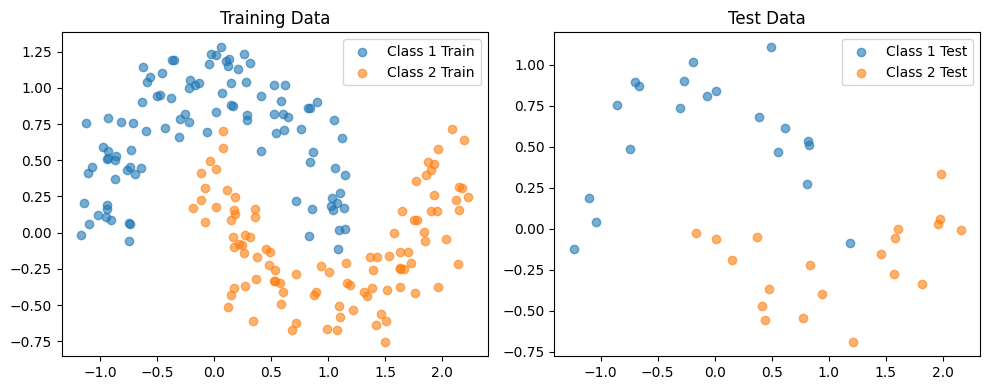

In [6]:
# Visualization
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], label="Class 1 Train", alpha=0.6)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label="Class 2 Train", alpha=0.6)
plt.title("Training Data")
plt.legend()

plt.subplot(122)
plt.scatter(X_test[y_test == -1, 0], X_test[y_test == -1, 1], label="Class 1 Test", alpha=0.6)
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], label="Class 2 Test", alpha=0.6)
plt.title("Test Data")
plt.legend()

plt.tight_layout()
plt.show()

# Data Encoding

In [7]:
num_qubits = 2
dev = qml.device("default.qubit", wires=num_qubits)

In [8]:
# Define several feature maps for encoding classical data into quantum states to check which is the best

def amplitude_embedding(x):
    """Amplitude embedding feature map"""
    qml.AmplitudeEmbedding(features=x, wires=range(num_qubits), normalize=True)

def angle_embedding(x):
    """Angle embedding feature map"""
    for i in range(num_qubits):
        qml.RY(x[i % len(x)], wires=i)

def strong_entangling_embedding(x):
    """Angle embedding with entangling layers"""
    for i in range(num_qubits):
        qml.RY(x[i % len(x)], wires=i)
    qml.CNOT(wires=[0, 1])
    for i in range(num_qubits):
        qml.RZ(x[i % len(x)], wires=i)

def IQP_embedding(x):
    """IQP (Instantaneous Quantum Polynomial) embedding"""
    for i in range(num_qubits):
        qml.Hadamard(wires=i)
        qml.RZ(x[i % len(x)], wires=i)
    for i in range(num_qubits):
        for j in range(i+1, num_qubits):
            qml.CNOT(wires=[i, j])
            qml.RZ((x[i % len(x)] * x[j % len(x)]), wires=j)
            qml.CNOT(wires=[i, j])

In [9]:
# Best enconding
selected_feature_map = angle_embedding

@qml.qnode(dev)
def quantum_circuit(x):
    """Quantum circuit that applies the selected feature map"""
    selected_feature_map(x)
    return qml.state()  # Returns the quantum state vector

In [10]:
# Test the quantum encoding with a sample data point
sample_point = X_train[0]
print("\nSample classical data point:", sample_point)
quantum_state = quantum_circuit(sample_point)
print("\nCorresponding quantum state (first 4 elements):", quantum_state[:4])


Sample classical data point: [1.04155111 0.15390583]

Corresponding quantum state (first 4 elements): [0.86486646+0.j 0.06668568+0.j 0.49608057+0.j 0.03825038+0.j]


In [11]:
# Function to transform entire dataset to quantum states
def classical_to_quantum(X):
    """Convert classical data to quantum state vectors"""
    quantum_data = []
    for x in X:
        quantum_state = quantum_circuit(x)
        quantum_data.append(quantum_state)
    return np.array(quantum_data)

In [12]:
# Convert training and test data to quantum states
print("\nConverting training data to quantum states...")
X_train_quantum = classical_to_quantum(X_train)
print("Converting test data to quantum states...")
X_test_quantum = classical_to_quantum(X_test)

print("\nQuantum training data shape:", X_train_quantum.shape)
print("Quantum test data shape:", X_test_quantum.shape)


Converting training data to quantum states...
Converting test data to quantum states...

Quantum training data shape: (200, 4)
Quantum test data shape: (40, 4)


In [13]:
# Visualization of the quantum states
def plot_quantum_states(X_quantum, y, title):
    """Plot quantum states in 3D space (first 3 dimensions)"""
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Take the absolute value of the quantum states for plotting because matplotlib expeccts real values
    X_quantum_real = np.abs(X_quantum)

    # Plot class 1
    class1 = X_quantum_real[y == -1]
    ax.scatter(class1[:, 0], class1[:, 1], class1[:, 2],
               label="Class 1", alpha=0.6)

    # Plot class 2
    class2 = X_quantum_real[y == 1]
    ax.scatter(class2[:, 0], class2[:, 1], class2[:, 2],
               label="Class 2", alpha=0.6)

    ax.set_title(title)
    ax.legend()
    plt.show()


Visualizing quantum training data...


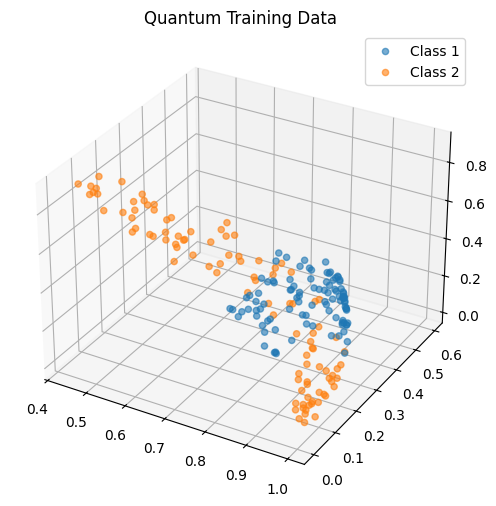


Visualizing quantum test data...


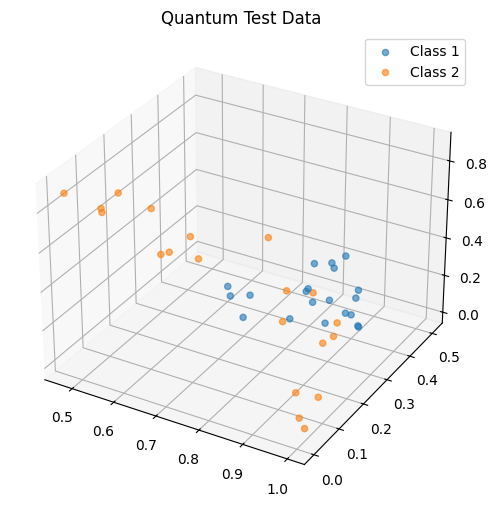

In [14]:
print("\nVisualizing quantum training data...")
plot_quantum_states(X_train_quantum, y_train, "Quantum Training Data")

print("\nVisualizing quantum test data...")
plot_quantum_states(X_test_quantum, y_test, "Quantum Test Data")

# Circuit Architecture

In [24]:
class VariationalQuantumClassifier:
    def __init__(self, num_qubits=2, num_layers=3, learning_rate=0.01, epochs=50,
                 loss_fn='mse', optimizer='adam'):
        """
        Initialize the Variational Quantum Classifier with customizable loss and optimizer

        Args:
            num_qubits (int): Number of qubits
            num_layers (int): Number of variational layers
            learning_rate (float): Learning rate for optimization
            epochs (int): Number of training epochs
            loss_fn (str): Loss function ('mse', 'hinge', 'cross_entropy')
            optimizer (str): Optimizer ('adam', 'sgd', 'rmsprop')
        """
        self.num_qubits = num_qubits
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.loss_fn = loss_fn
        self.optimizer = optimizer.lower()

        # Initialize device
        self.dev = qml.device("default.qubit", wires=num_qubits)

        # Initialize random parameters for the variational circuit
        shape = qml.StronglyEntanglingLayers.shape(n_layers=num_layers, n_wires=num_qubits)
        # Use pennylane.numpy for parameters to enable gradient tracking
        self.params = qnp.random.uniform(0, 2*qnp.pi, size=shape, requires_grad=True)

        # Define the quantum circuit
        self.circuit = qml.QNode(self._quantum_circuit, self.dev)

        # Initialize optimizer
        self._init_optimizer()

        # Initialize loss function
        self._init_loss_fn()

    def _init_optimizer(self):
        """Initialize the selected optimizer"""
        if self.optimizer == 'adam':
            self.opt = qml.AdamOptimizer(stepsize=self.learning_rate)
        elif self.optimizer == 'sgd':
            self.opt = qml.GradientDescentOptimizer(stepsize=self.learning_rate)
        elif self.optimizer == 'rmsprop':
            self.opt = qml.RMSPropOptimizer(stepsize=self.learning_rate)
        else:
            raise ValueError(f"Unknown optimizer: {self.optimizer}. Choose 'adam', 'sgd', or 'rmsprop'")

    def _init_loss_fn(self):
        """Initialize the selected loss function"""
        if self.loss_fn == 'mse':
            self.cost_fn = lambda params, X, y: qnp.mean((self.predict_proba(X, params) - y)**2)
        elif self.loss_fn == 'hinge':
            self.cost_fn = lambda params, X, y: qnp.mean(qnp.maximum(0, 1 - y * self.predict_proba(X, params)))
        elif self.loss_fn == 'cross_entropy':
            self.cost_fn = lambda params, X, y: qnp.mean(qnp.log(1 + qnp.exp(-y * self.predict_proba(X, params))))
        else:
            raise ValueError(f"Unknown loss function: {self.loss_fn}. Choose 'mse', 'hinge', or 'cross_entropy'")

    def _quantum_circuit(self, x, params):
        """Variational quantum circuit with data encoding and trainable layers"""
        angle_embedding(x) #i cant remove these because the circuit wont be able to see the data
        # Variational layers (using strongly entangling layers)
        qml.StronglyEntanglingLayers(params, wires=range(self.num_qubits))

        # Measurement - expectation value of Pauli Z on first qubit
        return qml.expval(qml.PauliZ(0))

    def predict_proba(self, X, params=None):
        """Predict probabilities (expectation values) for input data"""
        if params is None:
            params = self.params
        return qnp.array([self.circuit(x, params) for x in X])

    def predict(self, X, threshold=0.0):
        """Make class predictions (-1 or 1) based on expectation values"""
        probs = self.predict_proba(X)
        return np.where(probs > threshold, 1, -1)

    def fit(self, X_train, y_train):
        """Train the variational quantum classifier"""
        # Convert labels from [-1, 1] to expectation value range
        y_train = qnp.array(y_train, dtype=float)

        X_train_qnp = qnp.array(X_train)

        # Training history
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

        # Training loop
        for epoch in range(self.epochs):
            # Update parameters
            # Pass X_train_qnp to step_and_cost
            self.params, loss = self.opt.step_and_cost(
                self.cost_fn, self.params, X=X_train_qnp, y=y_train
            )

            # Calculate metrics
            # Use original X_train for prediction as circuit can handle it
            train_pred = self.predict(X_train)
            train_acc = accuracy_score(y_train, train_pred)

            history['train_loss'].append(loss.numpy())
            history['train_acc'].append(train_acc)


            # Print progress
            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch + 1}/{self.epochs} - Loss: {history['train_loss'][-1]:.4f} - Acc: {train_acc:.4f}")

        return history

    def evaluate(self, X_test, y_test):
        """Evaluate the model on test data and calculate multiple metrics"""
        test_pred = self.predict(X_test)
        # Accuracy
        test_acc = accuracy_score(y_test, test_pred)
        # Precision
        test_precision = precision_score(y_test, test_pred)
        # Recall
        test_recall = recall_score(y_test, test_pred)
        # F1-Score
        test_f1 = f1_score(y_test, test_pred)

        # Display all metrics
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Test Precision: {test_precision:.4f}")
        print(f"Test Recall: {test_recall:.4f}")
        print(f"Test F1-Score: {test_f1:.4f}")

# Training

In [30]:
print("Example 1: MSE loss with Adam optimizer")
vqc1 = VariationalQuantumClassifier(
    num_qubits=2,
    num_layers=3,
    learning_rate=0.05,
    epochs=30,
    loss_fn='mse',
    optimizer='adam'
)
history1 = vqc1.fit(X_train_quantum, y_train)
vqc1.evaluate(X_test_quantum, y_test)

Example 1: MSE loss with Adam optimizer
Epoch 5/30 - Loss: 0.9226 - Acc: 0.7400
Epoch 10/30 - Loss: 0.8278 - Acc: 0.8350
Epoch 15/30 - Loss: 0.7599 - Acc: 0.8500
Epoch 20/30 - Loss: 0.7111 - Acc: 0.8500
Epoch 25/30 - Loss: 0.7127 - Acc: 0.8200
Epoch 30/30 - Loss: 0.7168 - Acc: 0.8200
Test Accuracy: 0.8750
Test Precision: 0.8261
Test Recall: 0.9500
Test F1-Score: 0.8837


In [27]:
print("Example 2: Hinge loss with RMSProp optimizer")
vqc2 = VariationalQuantumClassifier(
    num_qubits=2,
    num_layers=3,
    learning_rate=0.03,
    epochs=30,
    loss_fn='hinge',
    optimizer='rmsprop'
)
history2 = vqc2.fit(X_train_quantum, y_train)
vqc2.evaluate(X_test_quantum, y_test)

Example 2: Hinge loss with RMSProp optimizer
Epoch 5/30 - Loss: 0.8421 - Acc: 0.7900
Epoch 10/30 - Loss: 0.8297 - Acc: 0.8050
Epoch 15/30 - Loss: 0.8290 - Acc: 0.8450
Epoch 20/30 - Loss: 0.8287 - Acc: 0.8200
Epoch 25/30 - Loss: 0.8284 - Acc: 0.8500
Epoch 30/30 - Loss: 0.8279 - Acc: 0.8150
Test Accuracy: 0.9000
Test Precision: 0.8636
Test Recall: 0.9500
Test F1-Score: 0.9048


In [31]:
print("Example 3: Cross-entropy loss with SGD optimizer")
vqc3 = VariationalQuantumClassifier(
    num_qubits=2,
    num_layers=3,
    learning_rate=0.01,
    epochs=30,
    loss_fn='cross_entropy',
    optimizer='sgd'
)
history3 = vqc3.fit(X_train_quantum, y_train)
vqc3.evaluate(X_test_quantum, y_test)

Example 3: Cross-entropy loss with SGD optimizer
Epoch 5/30 - Loss: 0.6634 - Acc: 0.5700
Epoch 10/30 - Loss: 0.6631 - Acc: 0.5700
Epoch 15/30 - Loss: 0.6627 - Acc: 0.5800
Epoch 20/30 - Loss: 0.6624 - Acc: 0.5950
Epoch 25/30 - Loss: 0.6621 - Acc: 0.6000
Epoch 30/30 - Loss: 0.6618 - Acc: 0.6050
Test Accuracy: 0.5500
Test Precision: 0.5263
Test Recall: 1.0000
Test F1-Score: 0.6897


In [32]:
# Plot comparison of different configurations
def plot_comparison(histories, labels):
    """Plot comparison of different training runs"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for hist, label in zip(histories, labels):
        plt.plot(hist['train_loss'], label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()

    plt.subplot(1, 2, 2)
    for hist, label in zip(histories, labels):
        plt.plot(hist['train_acc'], label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Comparison')
    plt.legend()

    plt.tight_layout()
    plt.show()

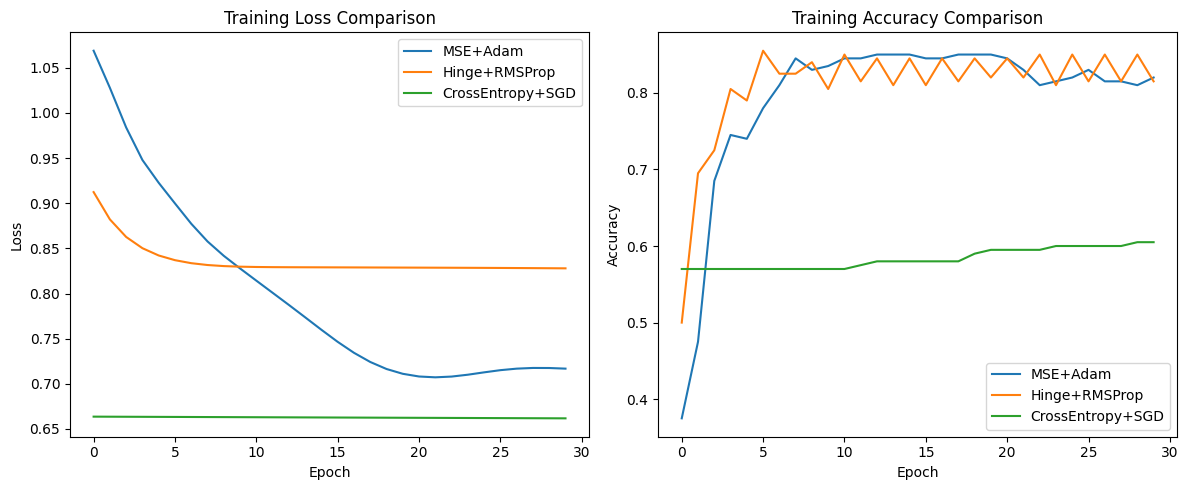

In [34]:
plot_comparison(
    [history1, history2, history3],
    ['MSE+Adam', 'Hinge+RMSProp', 'CrossEntropy+SGD']
)

# Block sphere visualization

In [60]:
def plot_all_data_on_bloch_sphere(X_quantum, y, title="Quantum States"):
    """Visualize quantum states on Bloch sphere"""
    print(title)
    # Initialize Bloch sphere
    b = Bloch()
    b.figsize = [10, 10]

    # Convert y to numpy array if it isn't already
    y = np.array(y).flatten()  # This fixes the float iteration error

    # Verify input shapes
    if len(X_quantum) != len(y):
        raise ValueError(f"Mismatched lengths: {len(X_quantum)} states vs {len(y)} labels")

    # Calculate Bloch vectors
    bloch_vectors = []
    for state in X_quantum:
        # Normalize and convert to Qobj
        state = np.array(state) / np.linalg.norm(state)

        if len(state) == 2:  # 1-qubit
            psi = Qobj(state, dims=[[2],[1]])
        elif len(state) == 4:  # 2-qubit
            psi = Qobj(state, dims=[[2,2],[1,1]]).ptrace(0)
        else:
            raise ValueError(f"Invalid state dimension: {len(state)}")

        # Calculate components
        x = (psi * sigmax()).tr().real
        y_comp = (psi * sigmay()).tr().real  # Renamed to avoid conflict
        z = (psi * sigmaz()).tr().real
        bloch_vectors.append([x, y_comp, z])

    bloch_vectors = np.array(bloch_vectors)

    # Add points with colors
    b.add_points(bloch_vectors.T)

    # Set point properties safely
    if len(y) > 0:
        b.point_color = ['r' if label == -1 else 'b' for label in y]
        b.point_size = [30] * len(y)

    # Customize view
    b.view = [-60, 30]
    return b.show()

Training Data Quantum States


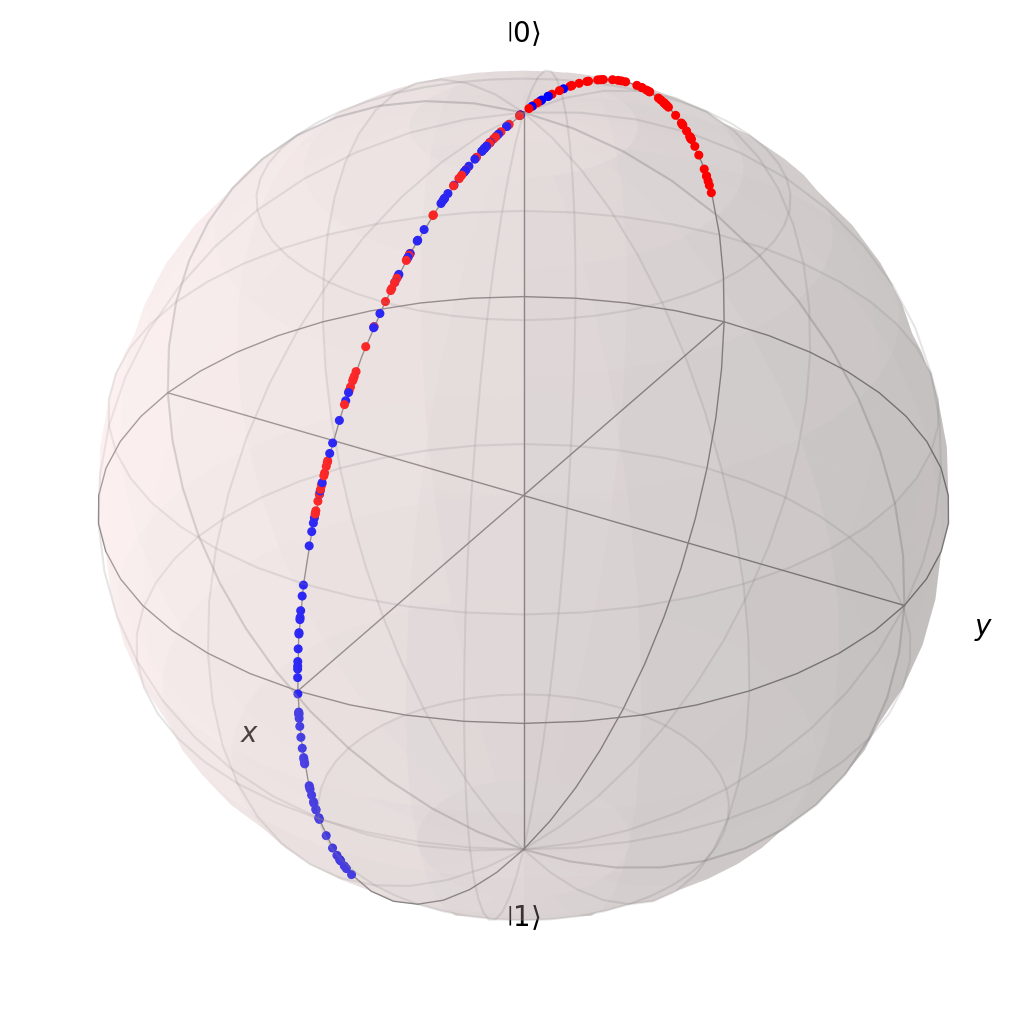

In [61]:
# Visualize training data
plot_all_data_on_bloch_sphere(X_train_quantum, y_train, "Training Data Quantum States")

In [58]:
def get_processed_states(vqc_model, X):
    """Returns full quantum states after processing by trained circuit"""
    processed_states = []
    for x in X:
        # Get the statevector after all operations
        @qml.qnode(vqc_model.dev)
        def state_prep_circuit(x, params):
            # Apply the exact same operations as your main circuit
            selected_feature_map(x)  # Your encoding
            qml.StronglyEntanglingLayers(params, wires=range(vqc_model.num_qubits))
            return qml.state()  # Returns the full state vector

        state = state_prep_circuit(x, vqc_model.params)
        processed_states.append(state)
    return np.array(processed_states)

Processed Quantum States (After Training)


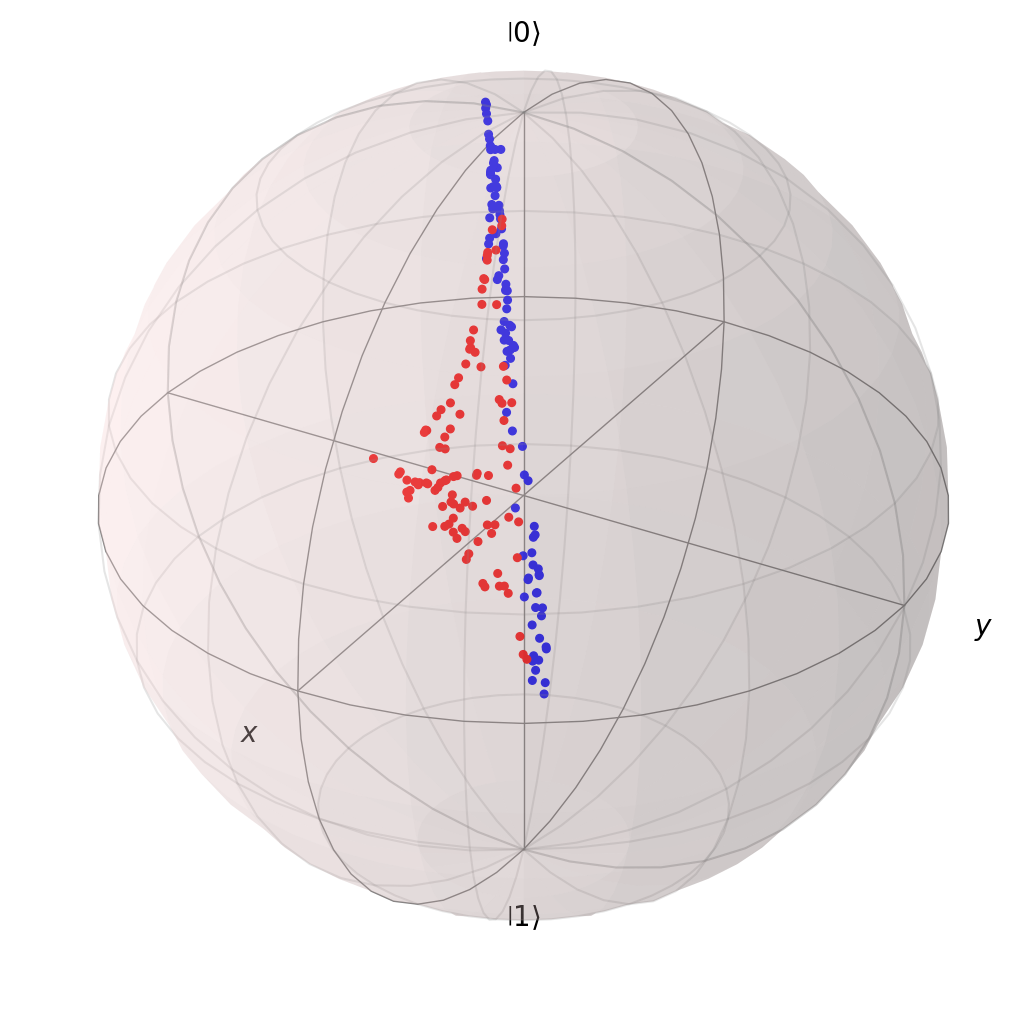

In [62]:
X_train_quantum_processed = get_processed_states(vqc1, X_train)
plot_all_data_on_bloch_sphere(X_train_quantum_processed, y_train, "Processed Quantum States (After Training)")

# Classical Comparison


Comparison between VQC and SVM:
Metric          SVM        VQC       
Accuracy        0.9750 0.8750
Precision       0.9524 0.8261
Recall          1.0000 0.9500
F1-Score        0.9756 0.8837


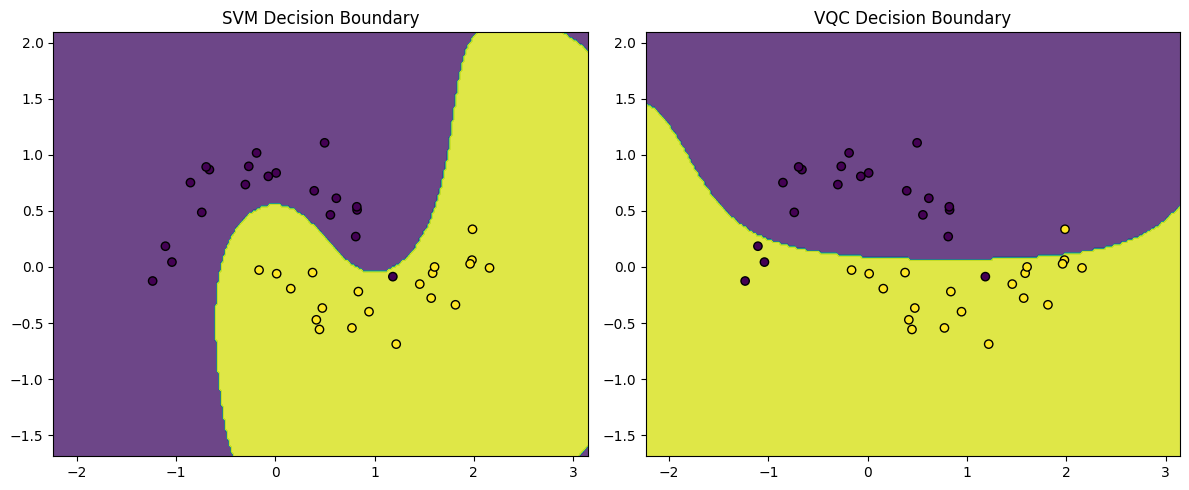

In [65]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

def compare_with_svm(X_train, y_train, X_test, y_test):
    """
    Compare the quantum classifier with a classical SVM
    """
    # Train SVM
    svm = SVC(kernel='rbf', gamma='scale', random_state=42)
    svm.fit(X_train, y_train)

    # Evaluate SVM
    svm_pred = svm.predict(X_test)
    svm_acc = accuracy_score(y_test, svm_pred)
    svm_precision = precision_score(y_test, svm_pred)
    svm_recall = recall_score(y_test, svm_pred)
    svm_f1 = f1_score(y_test, svm_pred)

    # Evaluate VQC (using vqc1 from your example)
    vqc_pred = vqc2.predict(X_test)
    vqc_acc = accuracy_score(y_test, vqc_pred)
    vqc_precision = precision_score(y_test, vqc_pred)
    vqc_recall = recall_score(y_test, vqc_pred)
    vqc_f1 = f1_score(y_test, vqc_pred)

    # Print comparison
    print("\nComparison between VQC and SVM:")
    print(f"{'Metric':<15} {'SVM':<10} {'VQC':<10}")
    print(f"{'Accuracy':<15} {svm_acc:.4f} {vqc_acc:.4f}")
    print(f"{'Precision':<15} {svm_precision:.4f} {vqc_precision:.4f}")
    print(f"{'Recall':<15} {svm_recall:.4f} {vqc_recall:.4f}")
    print(f"{'F1-Score':<15} {svm_f1:.4f} {vqc_f1:.4f}")

    # Plot decision boundaries for visual comparison
    plt.figure(figsize=(12, 5))

    # SVM decision boundary
    plt.subplot(1, 2, 1)
    h = 0.02  # step size in the mesh
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot SVM decision boundary
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k')
    plt.title('SVM Decision Boundary')

    # VQC decision boundary
    plt.subplot(1, 2, 2)
    Z = vqc2.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k')
    plt.title('VQC Decision Boundary')

    plt.tight_layout()
    plt.show()

# Run the comparison
compare_with_svm(X_train, y_train, X_test, y_test)